#Legacy Code from: Mentee Alumnus Batch 3 Startup Campus Batch 3: <br> Muhammad Alwiza Ansyar
https://www.linkedin.com/in/muhammad-alwiza-ansyar/

# Preperation

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from PIL import Image

import numpy as np

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

from collections import OrderedDict
import time,json
# from workspace_utils import active_session

In [2]:
data_dir = './data/'
train_dir = data_dir + '/train/'
val_dir = data_dir + '/validation/'
test_dir = data_dir + '/test/'

In [3]:
data_transforms_train = transforms.Compose([transforms.Resize(224),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])


data_transforms_test = transforms.Compose([transforms.Resize(224),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

In [ ]:
flowers102_train = datasets.Flowers102(
    train_dir, split="train", download=True,
    transform=data_transforms_train)
flowers102_val = datasets.Flowers102(
    val_dir, split="val", download=True,
    transform=data_transforms_train)
flowers102_test = datasets.Flowers102(
    test_dir, split="test", download=True,
    transform=data_transforms_train)

100%|██████████| 344862509/344862509 [00:17<00:00, 19677318.31it/s]


Extracting data/train/flowers-102/102flowers.tgz to data/train/flowers-102


100%|██████████| 502/502 [00:00<00:00, 451058.40it/s]


100%|██████████| 14989/14989 [00:00<00:00, 17819847.69it/s]


100%|██████████| 344862509/344862509 [00:18<00:00, 18986124.03it/s]


Extracting data/validation/flowers-102/102flowers.tgz to data/validation/flowers-102


100%|██████████| 502/502 [00:00<00:00, 484366.37it/s]


100%|██████████| 14989/14989 [00:00<00:00, 4528120.33it/s]


100%|██████████| 344862509/344862509 [00:22<00:00, 15385806.73it/s]


Extracting data/test/flowers-102/102flowers.tgz to data/test/flowers-102


# Choosing 17 classes

In [ ]:
# chosen labels are the last 17 classes by index
chosen_labels = {
  85: 'tree mallow',
  86: 'magnolia',
  87: 'cyclamen',
  88: 'watercress',
  89: 'canna lily',
  90: 'hippeastrum',
  91: 'bee balm',
  92: 'ball moss',
  93: 'foxglove',
  94: 'bougainvillea',
  95: 'camellia',
  96: 'mallow',
  97: 'mexican petunia',
  98: 'bromelia',
  99: 'blanket flower',
  100: 'trumpet creeper',
  101: 'blackberry lily'
}

chosen_labels_list = list(chosen_labels.keys())
chosen_labels_tensor = torch.LongTensor(chosen_labels_list)
print(chosen_labels_tensor)

tensor([ 85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
         99, 100, 101])


In [ ]:
train_valid_idx = list()

for i in enumerate(flowers102_train):
  label = i[1][-1]
  if chosen_labels.get(label) != None : # label is one of chosen_labels
    train_valid_idx.append(i[0])

flowers102_train_chopped = torch.utils.data.Subset(flowers102_train, train_valid_idx)

In [ ]:
val_valid_idx = list()

for i in enumerate(flowers102_val):
  label = i[1][-1]
  if chosen_labels.get(label) != None :
    val_valid_idx.append(i[0])

flowers102_val_chopped = torch.utils.data.Subset(flowers102_val, val_valid_idx)

In [ ]:
test_valid_idx = list()

for i in enumerate(flowers102_test):
  label = i[1][-1]
  if chosen_labels.get(label) != None :
    test_valid_idx.append(i[0])
  if len(test_valid_idx) >= 1122: # limit to 1122 so it is divisible by 34
    break

flowers102_test_chopped = torch.utils.data.Subset(flowers102_test, test_valid_idx)

In [ ]:
batch = 34 # GHC of 170 and 1122

train_dataloader = torch.utils.data.DataLoader(flowers102_train_chopped,batch_size=batch,shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(flowers102_val_chopped,batch_size=batch,shuffle=True)
test_dataloader = torch.utils.data.DataLoader(flowers102_test_chopped,batch_size=batch,shuffle=True)

In [ ]:
examples = enumerate(train_dataloader)
batch_idx, (example_data, example_targets) = next(examples)
example_targets.shape

torch.Size([34])

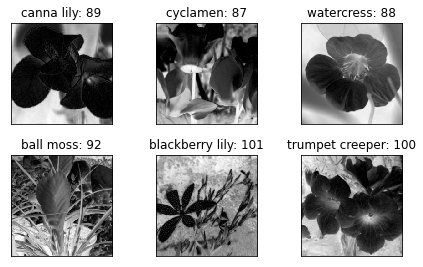

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow( example_data[i][0], cmap='binary', interpolation='none')
  plt.title("{}: {}".format( chosen_labels.get(int(example_targets[i])) , example_targets[i]) )
  plt.xticks([])
  plt.yticks([])

# Load pre-trained models, freeze them, and add new classifier layers

In [ ]:
model_vgg16 = models.vgg16(pretrained=True)
model_vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
for param in model_vgg16.parameters():
    param.requires_grad = False

In [ ]:
if hasattr(model_vgg16, 'classifier') :
  print(model_vgg16.classifier)
else :
  print("this model has no classifier")

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [ ]:
hidden_units = 1024
no_output_categories = len(chosen_labels)

new_vgg16_classifier = nn.Sequential(OrderedDict([
                            ('fc1', nn.Linear(25088,hidden_units)),
                            ('relu', nn.ReLU()),
                            ('dropout', nn.Dropout(0.5)),
                            ('fc2', nn.Linear(hidden_units,no_output_categories)),
                            ('output', nn.LogSoftmax(dim=1))
                            ]))

model_vgg16.classifier = new_vgg16_classifier
model_vgg16.classifier

Sequential(
  (fc1): Linear(in_features=25088, out_features=1024, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=17, bias=True)
  (output): LogSoftmax(dim=1)
)

In [ ]:
model_resnet34 = models.resnet34(pretrained=True)
model_resnet34

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
for name, param in model_resnet34.named_parameters():
  param.requires_grad = False

In [ ]:
if hasattr(model_resnet34, 'classifier') :
  print(model_resnet34.classifier)
else :
  print("this model has no classifier")

this model has no classifier


In [ ]:
hidden_units = 256
no_output_categories = len(chosen_labels)

new_resnet34_classifier = nn.Sequential(OrderedDict([
                            ('fc1', nn.Linear(512,hidden_units)),
                            ('relu', nn.ReLU()),
                            ('dropout', nn.Dropout(0.5)),
                            ('fc2', nn.Linear(hidden_units,no_output_categories)),
                            ('output', nn.LogSoftmax(dim=1))
                            ]))

# assigning classifier layer in fc layer
model_resnet34.fc = new_resnet34_classifier
model_resnet34.fc

Sequential(
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=17, bias=True)
  (output): LogSoftmax(dim=1)
)

In [ ]:
model_mobilenet_v2 = models.mobilenet_v2(pretrained=True)
model_mobilenet_v2

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
#Freeze the model
for param in model_mobilenet_v2.parameters():
    param.requires_grad = False

In [ ]:
if hasattr(model_mobilenet_v2, 'classifier') :
  print(model_mobilenet_v2.classifier)
else :
  print("this model has no classifier")

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


In [ ]:
hidden_units = 640
no_output_categories = len(chosen_labels)

new_mobilenet_v2_classifier = nn.Sequential(OrderedDict([
                            ('fc1', nn.Linear(1280,hidden_units)),
                            ('relu', nn.ReLU()),
                            ('dropout', nn.Dropout(0.5)),
                            ('fc2', nn.Linear(hidden_units,no_output_categories)),
                            ('output', nn.LogSoftmax(dim=1))
                            ]))

model_mobilenet_v2.classifier = new_mobilenet_v2_classifier
model_mobilenet_v2.classifier

Sequential(
  (fc1): Linear(in_features=1280, out_features=640, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=640, out_features=17, bias=True)
  (output): LogSoftmax(dim=1)
)

# Training setup

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
# helper function to match class code with output_layer index
def indexed_labels(tensor_labels):
  indexed_labels = list()
  for i in tensor_labels:
    indexed_labels.append(i - 85) # 85 because the first chosen class's code is 85

  return torch.LongTensor(indexed_labels)

# Training and Testing with vgg16

In [ ]:
epochs = 5
learning_rate = 0.0005
criterion = nn.NLLLoss()
print_every = 5

In [ ]:
model = model_vgg16

In [ ]:
model.to(device)

# Setting training hyperparameters
optimizer = optim.Adam(model.classifier.parameters(),lr=learning_rate)
running_loss = running_accuracy = 0
validation_losses, training_losses = [],[]

for e in range(epochs):
  batches = 0
  # Turning on training mode
  model.train()
  for images,labels in train_dataloader:

    labels = indexed_labels(labels)

    start = time.time()
    batches += 1
    # Moving images & labels to the GPU
    images,labels = images.to(device),labels.to(device)
    # Pushing batch through network, calculating loss & gradient, and updating weights
    log_ps = model.forward(images)
    loss = criterion(log_ps, labels)
    loss.backward()
    optimizer.step()
    # Calculating metrics
    ps = torch.exp(log_ps)
    top_ps, top_class = ps.topk(1,dim=1)
    matches = (top_class == labels.view(*top_class.shape)).type(torch.FloatTensor)
    accuracy = matches.mean()
    # Resetting optimizer gradient & tracking metrics
    optimizer.zero_grad()
    running_loss += loss.item()
    running_accuracy += accuracy.item()
    # Running the model on the validation set every 5 loops
    if batches%print_every == 0:
      end = time.time()
      training_time = end-start
      start = time.time()
      # Setting metrics
      validation_loss = 0
      validation_accuracy = 0
      # Turning on evaluation mode & turning off calculation of gradients
      model.eval()
      with torch.no_grad():
        for images,labels in valid_dataloader:

          labels = indexed_labels(labels)

          images,labels = images.to(device),labels.to(device)
          log_ps = model.forward(images)
          loss = criterion(log_ps,labels)
          ps = torch.exp(log_ps)
          top_ps, top_class = ps.topk(1,dim=1)
          matches = (top_class == \
                      labels.view(*top_class.shape)).type(torch.FloatTensor)
          accuracy = matches.mean()
          # Tracking validation metrics
          validation_loss += loss.item()
          validation_accuracy += accuracy.item()

      # Tracking metrics
      end = time.time()
      validation_time = end-start
      validation_losses.append(running_loss/print_every)
      training_losses.append(validation_loss/len(valid_dataloader))

      # Printing Results
      print(f'Epoch {e+1}/{epochs} | Batch {batches}')
      print(f'Running Training Loss: {running_loss/print_every:.3f}')
      print(f'Running Training Accuracy: {running_accuracy/print_every*100:.2f}%')
      print(f'Validation Loss: {validation_loss/len(valid_dataloader):.3f}')
      print(f'Validation Accuracy: {validation_accuracy/len(valid_dataloader)*100:.2f}%')
      print(f'Training Time: {training_time:.3f} seconds for {print_every} batches.')
      print(f'Validation Time: {validation_time:.3f} seconds.\n')

      # Resetting metrics & turning on training mode
      running_loss = running_accuracy = 0
      model.train()

Epoch 1/5 | Batch 5
Running Training Loss: 2.544
Running Training Accuracy: 27.06%
Validation Loss: 1.284
Validation Accuracy: 63.53%
Training Time: 18.177 seconds for 5 batches.
Validation Time: 91.515 seconds.

Epoch 2/5 | Batch 5
Running Training Loss: 0.198
Running Training Accuracy: 96.47%
Validation Loss: 0.774
Validation Accuracy: 72.94%
Training Time: 18.298 seconds for 5 batches.
Validation Time: 90.939 seconds.

Epoch 3/5 | Batch 5
Running Training Loss: 0.018
Running Training Accuracy: 100.00%
Validation Loss: 0.615
Validation Accuracy: 84.71%
Training Time: 18.098 seconds for 5 batches.
Validation Time: 90.942 seconds.

Epoch 4/5 | Batch 5
Running Training Loss: 0.005
Running Training Accuracy: 100.00%
Validation Loss: 0.645
Validation Accuracy: 80.00%
Training Time: 18.176 seconds for 5 batches.
Validation Time: 90.753 seconds.

Epoch 5/5 | Batch 5
Running Training Loss: 0.004
Running Training Accuracy: 100.00%
Validation Loss: 0.655
Validation Accuracy: 80.59%
Training Ti

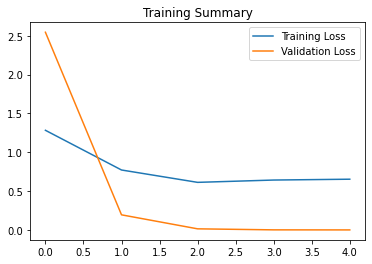

In [ ]:
plt.figure()
plt.title("Training Summary")
plt.plot(training_losses,label='Training Loss')
plt.plot(validation_losses,label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
test_accuracy = 0
counter = 0
for images,labels in test_dataloader:
    labels = indexed_labels(labels)

    model.eval()
    images,labels = images.to(device),labels.to(device)
    log_ps = model.forward(images)
    ps = torch.exp(log_ps)
    top_ps,top_class = ps.topk(1,dim=1)
    matches = (top_class == labels.view(*top_class.shape)).type(torch.FloatTensor)
    accuracy = matches.mean()
    test_accuracy += accuracy
print(f'Model Test Accuracy: {test_accuracy/len(test_dataloader)*100:.2f}%')

Model Test Accuracy: 76.29%
